# 🎬 Movie Tags Extraction with LDA Model
By Shawn Shisen Yue on August 31th, 2022

## Introduction 
***
As a movie fan, I’m always strict about selecting a movie for my scarce holidays. Instead of blindly choosing a blockbuster movie, I prefer to scrutinize the movie recommendation websites to choose a movie that might not be popular, but perfectly fits my desire. In the process of looking for movies, I find my focus usually falls on two sites——the tags attached to the movie and the comments from the viewers. It seems like sometimes apart from the category the movie is classified in, such as comedies, or romantic movies, the elements that appear in a movie are more helpful for my search. For instance, if the name “suspension film” appears on the recommendation page, I probably wouldn’t pay any attention to it, while if the tag “psychopathic killer” is added, I would be very likely to click in to see if that’s my target film. The accurate tags on the films can not only benefit the viewers, but they can also help improve the performance of recommendation systems and thus can indirectly boosts their profit. Considering that most movie fans are not selecting films simply based on the rough categories, or the genres, it might be more appropriate to push the films on the basis of the tags on the movies they’ve recently seen. Furthermore, such a tag-attaching system also helps those movies with less popularity but with highlighted characteristics to gain more viewers, which could facilitate the diversification of the movie industry. 

Movies tagging has been researched extensively with natural language processing and machine learning methods. In a study by Khan et al.[1], they trained a Convolution Neural Network based on a carefully constructed tag vocabulary to extract the keywords from the keyframes in the movie, and achieved good accuracy in their evaluation. In a study conducted by Kar et al.[2], researchers came up with a model which can extract tags on the basis of a paragraph of synopses about the movie. The researchers found an obvious superiority in the relevance and attractiveness of the model’s outcome over the keywords extracted by humans. Moreover, they put forwards a list of requirements for the synopses used for tag-extraction. The result of this study demonstrates the feasibility of generating tags with a synopsis of the movie. 

This notebook is a preliminary attempt to create tags for movies found on Netflix based on information in the *Netflix Movies and TV Shows* dataset. In the project, I first imported and pre-processed the data by means of changing data types and creating lists and dictionaries. Then I conducted an exploratory data analysis to seek some relevance between the columns. In this process, I found some insights about the movie industry through plotting, such as the developing trend of the duration. Finally, by observation I found the descriptions of the movies, which mostly contain one or two sentences, reveal many key words of the movie and might be suitable for tag-producing. Specifically, I established a corpus which includes all words in the descriptions of the movies of the same category and used LDA model to give some featured words for that movie category. The result of this analysis shows the possibility of utilizing a paragraph of description to extract the topic words of a given category of movies.

## Methods
***
### Dataset Introduction
This notebook includes a movie dataset from <https://www.kaggle.com/datasets/shivamb/netflix-shows>, which consists of listings of all the **movies** and **TV-shows** available on **Netflix**, along with details such as - cast, directors, ratings, release year, duration, etc.

Specifically, here's the meaning of each column in the dataset:

    show_id: Unique ID for every Movie / Tv Show 
    type: Identifier - A Movie or TV Show
    title: Title of the Movie / Tv Show
    director: Director of the Movie
    cast: Actors involved in the movie / show
    country: Country where the movie / show was produced
    date_added: Date it was added on Netflix
    release_year: Actual Release year of the move / show
    rating: TV Rating of the movie / show
    duration: Total Duration - in minutes or number of seasons
    listed_in: Genere
    description: The summary description
    
### LDA model 
Latent Dirichlet allocation (LDA) is a widey used **topic-generating** model [3]. The model can identify the representative topics underlying a document collection or a corpus. This model produces topics based on **bag-of-word feature**, that each document is represented as a vector, in which every word corresponds to an id and its **appearing frequency** in the document. When producing the topics, The model samples a document-specific multinomial distribution over topics from Dirichlet distribution, and samples the word in the document from the corresponding multinomial distribution. 

Despite the extensive use of this model, it has some drawbacks. First, though the bag-of-word feature processes the text into digital information which is easy for modeling, it ignores the order between words and thus simplifies the problem. Moreover, the number of generated topic is hard to determine, so it's necessary to apply some other methods to evaluate the accuracy. This notebook uses LDA model to generate some descriptive word under a given topic name, which is a classified genere of movie in Netflix, so there's only one topic corresponding to a collection of document. 

## 📊 Exploratory Analysis & Results
***

### 1. 🎥 Data Preprocessing 

In [1]:
# Import the necessary libraries.

import pandas as pd
import nltk
import matplotlib.pyplot as plt
import ipywidgets
import gensim
import re
import wordcloud

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models

In [2]:
# Import the dataset.

df = pd.read_csv("data/netflix_titles.csv")

In [3]:
# Create a subset for movies.

movies = df[df["type"]=="Movie"]
movies.index = range(len(movies))

In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6131 non-null   object
 1   type          6131 non-null   object
 2   title         6131 non-null   object
 3   director      5943 non-null   object
 4   cast          5656 non-null   object
 5   country       5691 non-null   object
 6   date_added    6131 non-null   object
 7   release_year  6131 non-null   int64 
 8   rating        6129 non-null   object
 9   duration      6128 non-null   object
 10  listed_in     6131 non-null   object
 11  description   6131 non-null   object
dtypes: int64(1), object(11)
memory usage: 574.9+ KB


<AxesSubplot:>

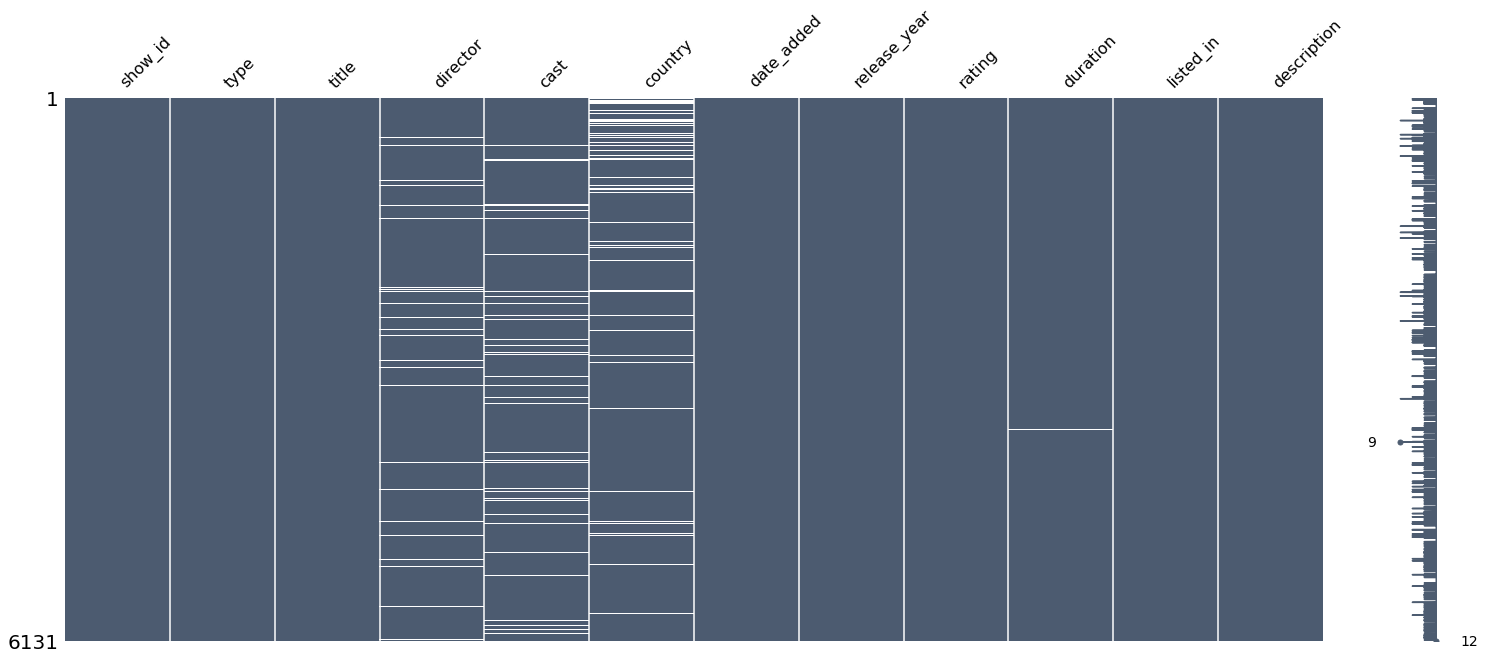

In [5]:
# Visualize the missing values in the dataframe.

import missingno as msno
msno.matrix(movies,color=(0.3,0.36,0.44))

**🍿️Comment**: The missing values are distributed in columns "director", "cast", "country" and "duration". 

In [6]:
# Display several rows in the dataframe.

movies.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
2513,s3979,Movie,Oversize Cops,"Chanon Yingyong, Phuwanit Pholdee","Sarun Cinsuvapala, Pramote Pathan, Suphachai S...",Thailand,"March 23, 2019",2017,TV-MA,100 min,"Action & Adventure, Comedies, International Mo...","While investigating a bank robbery, a squad of..."
1858,s2838,Movie,Twin Murders: the Silence of the White City,Daniel Calparsoro,"Belén Rueda, Javier Rey, Aura Garrido, Manolo ...",Spain,"March 6, 2020",2020,TV-MA,110 min,"International Movies, Thrillers",A detective returns to Vitoria-Gasteiz to solv...
76,s135,Movie,Clear and Present Danger,Phillip Noyce,"Harrison Ford, Willem Dafoe, Anne Archer, Joaq...","United States, Mexico","September 1, 2021",1994,PG-13,142 min,"Action & Adventure, Dramas","When the president's friend is murdered, CIA D..."
5058,s7474,Movie,Mission: Destroy Love,Osman Ali,"Bront Palarae, Maya Karin, Remy Ishak, Izara A...",Malaysia,"August 7, 2017",2014,TV-PG,93 min,"Comedies, International Movies, Romantic Movies",Two strangers meet by chance on a trip to Thai...
5798,s8403,Movie,The Longshots,Fred Durst,"Ice Cube, Keke Palmer, Tasha Smith, Jill Marie...",United States,"January 30, 2019",2008,PG,95 min,"Comedies, Dramas, Sports Movies",When an 11-year-old girl becomes Pop Warner fo...


**🍿️Comment**：Through observation, I found the values in the column **"duration"** are strings, but are mostly digital information. Therefore I convert them into integers. Also, the values in **"date_added"** are strings, which are more appropriate to be displayed as the date values for subsequent plotting. 

In [7]:
for i in range(len(movies)):
    if type(movies.loc[i,'duration']) == str:
        movies.loc[i,'duration'] = int(movies.loc[i,'duration'].replace(' min', ''))

In [8]:
movies.sample()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
307,s468,Movie,Private Network: Who Killed Manuel Buendía?,Manuel Alcalá,Daniel Giménez Cacho,NaN,"July 14, 2021",2021,TV-MA,100,"Documentaries, International Movies",A deep dive into the work of renowned Mexican ...


In [9]:
pd.to_datetime(movies['date_added'])

0      2021-09-25
1      2021-09-24
2      2021-09-24
3      2021-09-24
4      2021-09-23
          ...    
6126   2016-03-09
6127   2019-11-20
6128   2019-11-01
6129   2020-01-11
6130   2019-03-02
Name: date_added, Length: 6131, dtype: datetime64[ns]

Now that all duration values are converted into integer, let's begin our exploratory analysis. 

### 2. 📈Exploratory Analysis

First let's make some plots based on the **"duration"** and **"released_year"** columns

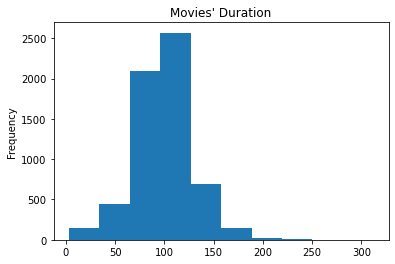

In [10]:
movies['duration'].plot(kind = 'hist')
plt.title("Movies' Duration")
plt.show()

**🍿️Comment**: The histogram shows that most movies on Netflix are about 100 minutes. The longest movie contained in this dataframe is about to reach 300 minutes, nearly 5 hours.

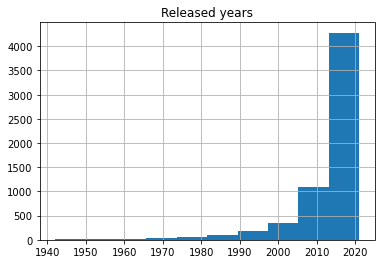

In [11]:
movies['release_year'].hist(xlabelsize = 10)
plt.title("Released years")
plt.show()

**🍿️Comment**: Most movies included in the dataframe are released in recent 10 years.

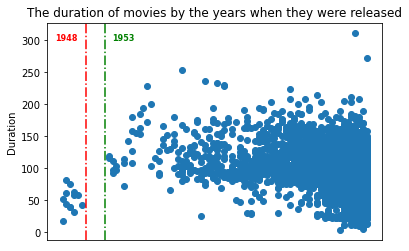

In [29]:
fig,ax = plt.subplots()
ax.scatter(movies['release_year'], movies['duration'])
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Duration')
ax.set_title('The duration of movies by the years when they were released')
plt.axvline(1948,c='r',ls='-.')
plt.axvline(1953,c='g',ls='-.')
plt.annotate('1948', xy=(1948, 300), xytext=(1940, 300),
            weight='bold', color='red',fontsize=8)
plt.annotate('1953', xy=(1953, 300), xytext=(1955, 300),
            weight='bold', color='green',fontsize=8)
plt.show()

**🍿️Comment**: In this graph we can see that the duration of all movies shot before 1948 are below 100 minutes, while many movies released after 1953 are over 100 minutes. The length of a movie is strongly related to the narrative style, the length of the story, and the scale of the background setting. From this we can make a reasonable guess that the movie industry grew mature in 1950s, with the better shotting equipments and more experienced directors. The short movies didn't quit the stage, however. In recent 10 years, there are still many movies with the duration below 50 minutes. 

Then Let's examine the values in "country" column.

As there are some regions instead of independent countries involved in this dataframe, so I changed the name of this column.

In [13]:
movies = movies.rename(columns={"country":"country_or_region"})
movies.sample()

,show_id,type,title,director,cast,country_or_region,date_added,release_year,rating,duration,listed_in,description
1778,s2715,Movie,Violet Evergarden: Eternity and the Auto Memor...,Haruka Fujita,"Yui Ishikawa, Minako Kotobuki, Aoi Yuki",Japan,"April 2, 2020",2019,TV-PG,91,"Anime Features, International Movies, Sci-Fi &...",A lonely young woman feels trapped at her all ...


In [14]:
# Create two list of movies to inlude the movies produced in mainland China and Hong Kong.

China_list = []
for i in range(6131):
    if "China" in movies['country_or_region'].astype(str).iloc[i]:
        China_list.append(i)
China = movies.iloc[China_list]
China.reset_index()

Hong_Kong_list = []
for i in range(6131):
    if "Hong Kong" in movies['country_or_region'].astype(str).iloc[i] and "China" not in movies['country_or_region'].astype(str).iloc[i]:
        Hong_Kong_list.append(i)
Hong_Kong = movies.iloc[Hong_Kong_list]
Hong_Kong.reset_index()

,index,show_id,type,title,director,cast,country_or_region,date_added,release_year,rating,duration,listed_in,description
0,97,s160,Movie,Love in a Puff,Pang Ho-cheung,"Miriam Chin Wah Yeung, Shawn Yue, Singh Hartih...",Hong Kong,"September 1, 2021",2010,TV-MA,103,"Comedies, Dramas, International Movies",When the Hong Kong government enacts a ban on ...
1,322,s487,Movie,Ratchet and Clank,"Jericca Cleland, Kevin Munroe","Paul Giamatti, John Goodman, Bella Thorne, Ros...","Hong Kong, Canada, United States","July 9, 2021",2016,PG,94,"Children & Family Movies, Comedies, Sci-Fi & F...",Affable alien Ratchet longs to be a Galactic R...
2,1013,s1550,Movie,The Professor and the Madman,Farhad Safinia,"Mel Gibson, Sean Penn, Natalie Dormer, Eddie M...","Ireland, France, Iceland, United States, Mexic...","December 15, 2020",2019,TV-14,125,"Dramas, Independent Movies",While working on the first Oxford English Dict...
3,1055,s1621,Movie,Peppermint,Pierre Morel,"Jennifer Garner, John Ortiz, John Gallagher Jr...","Hong Kong, United States","December 1, 2020",2018,R,102,Action & Adventure,"After her family is murdered, a mild-mannered ..."
4,1346,s2060,Movie,Adrift,Baltasar Kormákur,"Shailene Woodley, Sam Claflin, Jeffrey Thomas,...","Hong Kong, Iceland, United States","September 1, 2020",2018,PG-13,96,"Action & Adventure, Dramas, Romantic Movies",A young couple’s sailing adventure becomes a f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,5722,s8307,Movie,The Flying Guillotine,Meng Hua Ho,"Kuan Tai Chen, Feng Ku, Hung Wei, Wu Chi Liu, ...",Hong Kong,"July 28, 2018",1975,TV-MA,101,"Action & Adventure, Dramas, International Movies","In Qing-dynasty China, the emperor commands th..."
59,5805,s8410,Movie,The Mad Monk,Johnny To,"Stephen Chow, Maggie Cheung, Anthony Wong Chau...",Hong Kong,"August 16, 2018",1993,TV-14,85,"Comedies, International Movies, Sci-Fi & Fantasy","To avoid punishment for his misdeeds, an arrog..."
60,5934,s8570,Movie,The Young Vagabond,Sze Yu Lau,"Chia-Hui Liu, Wong Yu, Jason Pai Piao, Lung We...",Hong Kong,"August 16, 2018",1985,TV-14,85,"Action & Adventure, Comedies, International Mo...","To avenge his master, a wine-loving young man ..."
61,6055,s8712,Movie,Weeds on Fire,Chi Fat Chan,"Liu Kai Chi, Lam Yiu-sing, Tony Tsz-Tung Wu, P...",Hong Kong,"September 27, 2018",2016,TV-MA,95,"Dramas, Independent Movies, International Movies","In 1980s Hong Kong, a school principal forms a..."


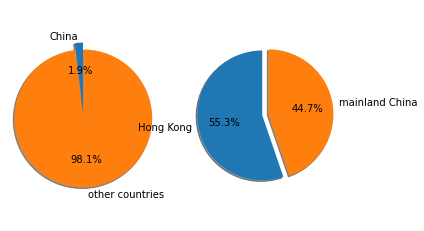

In [15]:
# Plot piecharts.

label1 = 'China', 'other countries'
label2 = 'Hong Kong', 'mainland China'
size1 = [114, 6017]
size2 = [63, 51]
explode = (0.1,0)  

fig, axs = plt.subplots(1, 2)
axs[0].pie(size1, explode=explode, labels=label1, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].pie(size2, explode=explode, labels=label2, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].axis('equal')
axs[1].axis('equal')
plt.show()

**🍿️Comment**: Few films produced in mainland China are available on Netflix. The number of movies on Netflix produced in Hong Kong even surpasses that of mainland China.

Then let's look at the data in "director" column.

In [16]:
# Create a dictionary to store the number of films each director shot. 

directors = {}
for i in range(len(movies)):
    if movies.loc[i,'director'] not in directors:
        directors[movies.loc[i,'director']] = 1
    else:
        directors[movies.loc[i,'director']] += 1

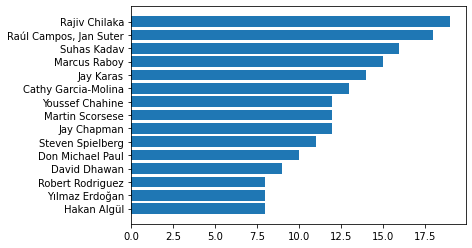

In [17]:
# Choose the top 15 directors according to the number of directors they produced in the dataframe. 

top_15_directors = sorted(directors.items(),key=lambda s:s[1],reverse=True)[1:16]
fig,ax = plt.subplots()
top_15 = [i[0] for i in top_15_directors]
movie_num = [j[1] for j in top_15_directors]
ax.barh(top_15,movie_num)
ax.invert_yaxis()
plt.show()

**🍿️Comment**: The names in the ranking is out of my prediction. As a fan of Christopher Nolan, I thought he should have been ranked very high, so I searched the number of his movies included in this dataframe. Moreover, I examined the information of movies directed by Rajiv Chilaka, who directs the most movies in this dataframe. 

In [18]:
directors['Christopher Nolan']

1

In [23]:
Rajiv = []
for i in range(len(movies)):
    if movies.loc[i,'director'] == 'Rajiv Chilaka':
        Rajiv.append(i)
Rajiv_list = movies.iloc[Rajiv]
Rajiv_list

,show_id,type,title,director,cast,country_or_region,date_added,release_year,rating,duration,listed_in,description
259,s407,Movie,Chhota Bheem - Neeli Pahaadi,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",NaN,"July 22, 2021",2013,TV-Y7,64,Children & Family Movies,Things get spooky when Bheem and his buddies t...
260,s408,Movie,Chhota Bheem & Ganesh,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",NaN,"July 22, 2021",2009,TV-Y7,68,Children & Family Movies,Bheem and Lord Ganesha join forces to save Dho...
261,s409,Movie,Chhota Bheem & Krishna: Mayanagari,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",NaN,"July 22, 2021",2011,TV-Y7,67,Children & Family Movies,Young lord Krishna has fallen for demoness Maa...
262,s410,Movie,Chhota Bheem & Krishna: Pataliputra- City of t...,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",NaN,"July 22, 2021",2010,TV-Y7,66,Children & Family Movies,Krishna needs Bheem’s help: The ruined city of...
263,s411,Movie,Chhota Bheem And The Broken Amulet,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",India,"July 22, 2021",2013,TV-Y7,64,Children & Family Movies,When a stranger tries to steal an amulet from ...
264,s412,Movie,Chhota Bheem And The Crown of Valhalla,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",NaN,"July 22, 2021",2013,TV-Y7,64,Children & Family Movies,To save the kingdom of Valhalla from invasion ...
265,s413,Movie,Chhota Bheem and the Incan Adventure,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",NaN,"July 22, 2021",2013,TV-Y7,65,Children & Family Movies,"When Dholakpur’s princess is kidnapped, Bheem ..."
266,s414,Movie,Chhota Bheem and The ShiNobi Secret,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",NaN,"July 22, 2021",2013,TV-Y7,64,Children & Family Movies,After learning of a samurai village under thre...
267,s415,Movie,Chhota Bheem Aur Hanuman,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",NaN,"July 22, 2021",2012,TV-Y7,68,Children & Family Movies,When two evil entities kidnap a princess in a ...
268,s416,Movie,Chhota Bheem aur Krishna,Rajiv Chilaka,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",India,"July 22, 2021",2009,TV-Y7,68,Children & Family Movies,"Centuries after the end of a conqueror's rule,..."


🍿️**Comment**: That's totally different from what I thought it would be. 
I had been originally interested in analyzing the directors and their preferences for different movie generes until I found that nearly all the movies produced by Rajiv Chilaka are Children & Family movies, and there are few movies directed by the well-known director "Chistopher Nolan" included in this dataframe. The lack of data made me afraid that I might not reach an impressive outcome and insight through the analysis, so I changed my research question.

Let's then move on to process the category information of the movies.

In [29]:
# First create a list containing the names of categories.

categories = []
for i in range(len(movies)):
    for w in movies.loc[i,'listed_in'].split(", "):
        if w not in categories:
            categories.append(w)

In [30]:
# Create a list storing the number of movies in each category. 

NumberByTypes = []
for i in range(len(categories)):
    count = 0
    for x in range(len(movies)):
        if categories[i] in movies.loc[x,'listed_in'].split(", "):
            count += 1
    NumberByTypes.append(count)

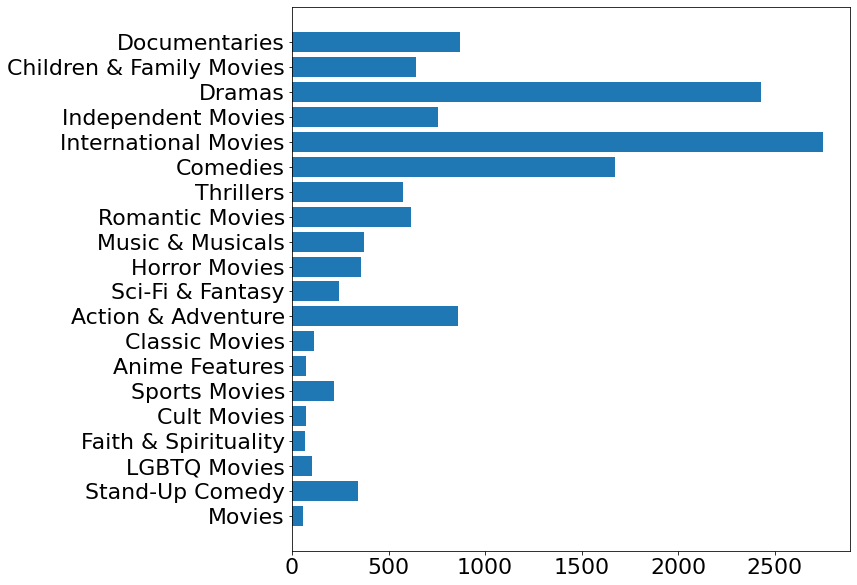

In [31]:
# Visualize the information.

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(categories,NumberByTypes)
ax.invert_yaxis()
plt.tick_params(labelsize=22)

**🍿️Comments**: 
1. Apart from those movies that have been clearly categorized, there's a type named "Movies", which suggests that movies in this type are not categorized due to some reason. We will examine the content of these movies and determine how should they be classified.
2. There aren't clear boundary between some of the categories, which means a movie can have multiple categories. The dim boundary may confuse the viewers and thus it's necessary to give these movies representative tags. 
3. Through the names of some categories we can roughly predict the content of the movies. For instance, Faith & Spirituality movies may contain a lot of religious elements. This provides the possibility for the afterwards tag prediction task based on the descriptions of movies.

### 3. 🏷 Tags Extraction

In this section, I used **the LDA model** to analyze the descriptions of a certain category of movie and extract the keywords to represent the category. Specifically, I first used **nltk** to preprocess the description texts. Then I made a **dictionary** and a **corpus** based on the tokenized and stemmed words. Finally, I used the LDA model to extract the keywords depending on appearing frequency and drew the **word cloud** graph to visualize the result.

In [32]:
# Create a list to store the descriptions of movies from different categories. 

DescByTypes = []
for i in range(len(categories)):
    DescByTypes.append([movies.loc[x,'description'] for x in range(len(movies)) if categories[i] in movies.loc[x,'listed_in'].split(', ')])

In [33]:
# First try to predict some tags for Documentaries.

Documentaries = DescByTypes[0]

In [34]:
# Create a list for tokenized words and remove those stop words.

myStopWords = list(punctuation) + stopwords.words('english')
Docu = []
for i in Documentaries:
    Docu.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])

In [35]:
# Stem the words in this list.

p_stemmer = PorterStemmer()
Docu_stemmed = []
for i in Docu:
    Docu_stemmed.append([p_stemmer.stem(w) for w in i])

In [36]:
# Create a dictionary for this document.

dictionary = corpora.Dictionary(Docu_stemmed)
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [37]:
print(dictionary.token2id)

{'comic': 0, 'death': 1, 'end': 2, 'face': 3, 'father': 4, 'filmmak': 5, 'help': 6, 'life': 7, 'stage': 8, 'way': 9, 'becam': 10, 'close': 11, 'document': 12, 'escap': 13, 'hitler': 14, 'presid': 15, 'reveal': 16, 'spain': 17, 'world': 18, "'s": 19, 'big': 20, 'childhood': 21, 'dream': 22, 'live': 23, 'love': 24, 'rescu': 25, 'train': 26, 'archiv': 27, 'champion': 28, 'documentari': 29, 'footag': 30, 'interview': 31, 'intim': 32, 'michael': 33, 'portrait': 34, 'trace': 35, 'bond': 36, 'extraordinari': 37, 'ideal': 38, 'meet': 39, 'tragic': 40, 'captur': 41, 'killer': 42, 'mother': 43, 'polic': 44, 'two': 45, 'victim': 46, 'women': 47, 'work': 48, 'chart': 49, 'legendari': 50, 'man': 51, 'stori': 52, 'use': 53, 'american': 54, 'challeng': 55, 'chang': 56, 'continu': 57, 'health': 58, 'tradit': 59, 'win': 60, 'gener': 61, 'last': 62, 'peopl': 63, 'togeth': 64, 'cultur': 65, 'examin': 66, 'famili': 67, 'hip-hop': 68, 'perform': 69, 'race': 70, 'rap': 71, 'song': 72, 'violenc': 73, "''": 7

As seen above, each word corresponds to a unique number in the dictionary.

In [38]:
# Make a corpus.

corpus = [dictionary.doc2bow(text) for text in Docu_stemmed]

In [39]:
# Train the lda model based on the dictionary and the corpus.

ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)

In [40]:
ldamodel.show_topics(num_topics=1)

[(0,
  '0.039*"documentari" + 0.030*"\'s" + 0.012*"life" + 0.010*"world" + 0.010*"explor" + 0.010*"follow" + 0.009*"``" + 0.009*"\'\'" + 0.009*"film" + 0.007*"stori"')]

**🍿Comment**: 
1. The number in front of each word is measured based on the appearing frequency of the word in the document, and can be explained as the recommendation rate to choose the word as the topic word.
2. Some of the words such as "documentary", "explore", and "world" accurately reflect the content of this category, which proves the feasibility of this task.
3. There are many punctuations and uninformative words involved in this list, so the next step is to add these strings into the stop words list to remove them from the dictionary. 

In [41]:
myStopWords.extend(["'s","'","·","``",'"','—'])

In [42]:
# Make an interactive visualization to reveal the predicted tags for each category.

def visualize1(m):
    Desc = []
    for i in DescByTypes[m]:
        Desc.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])
    p_stemmer = PorterStemmer()
    Desc_stemmed = []
    for i in Desc:
        Desc_stemmed.append([p_stemmer.stem(w) for w in i])
    dictionary = corpora.Dictionary(Desc_stemmed)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in Desc_stemmed]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)
    fig,ax = plt.subplots()

    x = []
    y = []
    count = 0
    for i in re.split(re.escape(' + ') + '|' + re.escape('*'), ldamodel.print_topics(num_topics=1, num_words=20)[0][1]):
        if count % 2 == 0:
            y.insert(0,float(i))
        else:
            x.insert(0,i)
        count += 1
    ax.barh(x,y,height=0.5)
    ax.set_title(categories[m])
    plt.tight_layout()
ipywidgets.interact(visualize1,m=(0,19))

interactive(children=(IntSlider(value=9, description='m', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.visualize1(m)>

**🍿Comments**: 
1. The tag words in most categories can accurately reflect the content of the movies invovled in that category, such as "gay", "love" and "teen" for LGBTQ movies, "murder", "mystery", "secret" and "killer" for Thrillers and "team", "player", "soccer" and "champion" for sports movies. 
2. By adding those punctuations into myStopWords, there are mostly meaningful words in the graphs.
3. The "Movies" category that I mentioned before might be some movies themed on holidays, because of the keywords "friend", "christma" and "holiday" in the chart. 

To visualize this information, I found wordcloud is pretty helpful.

In [43]:
# Visualize the tag words through wordcloud. 

def visualize(m):
    Desc = []
    for i in DescByTypes[m]:
        Desc.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])
    p_stemmer = PorterStemmer()
    Desc_stemmed = []
    for i in Desc:
        Desc_stemmed.append([p_stemmer.stem(w) for w in i])
    dictionary = corpora.Dictionary(Desc_stemmed)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in Desc_stemmed]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)

    x = []
    y = []
    count = 0
    for i in re.split(re.escape(' + ') + '|' + re.escape('*'), ldamodel.print_topics(num_topics=1, num_words=20)[0][1]):
        if count % 2 == 0:
            y.insert(0,float(i))
        else:
            x.insert(0,i)
        count += 1
    plt.figure(figsize=(20,20))
    frequencies = {}
    for a in x:
        frequencies[a]=y[x.index(a)]
    plt.title(categories[m]+'\n', fontsize=30, weight=600, color='#333d29')
    wc = wordcloud.WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(x))
    word_cloud = wc.generate_from_frequencies(frequencies)

    plt.imshow(wc)
ipywidgets.interact(visualize,m=(0,19))

interactive(children=(IntSlider(value=9, description='m', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.visualize(m)>

**🍿Comments**: 
The wordcloud graph really add much funs in this project and makes the outcome more readable. To be specific, I set the scale of the words to be aligned with the frequency they appeared in the document. Though there are still several meaningless marks and some of the words are not closely related to the category, there are still several useful words that can generalize the category. 

**🌟A Little Idea**:
After I've done this, it occurs to me an interesting game, which is to use mainly the words provided in the graph to form a sentence related to that category. For instance, we form a sentence related to Documentaries with the words in the first graph——"Documentaries are footages about people exploring the world and telling their stories".

## Discussion
***
In this project, I successfully extracted the representative keywords from a list of movie descriptions with the LDA model, and visualize them through several word cloud graphs, displaying the feasibility of extracting the featured words from a set of short sentences that share some common characteristics. However, this project is still immature and could be improved in the following aspects. 

- First, based on the requirement on synopses come up with by Kar et al.[2], the synopses of the movies used for tag-extracting should be at least 10 sentences, as understanding stories from a very short text would be difficult for any learning system, so if extracting tags from a single movie is the next-step goal, then acquiring a set of more specific synopses is necessary. 

- Furthermore, there could be interdisciplinary methods applied, such as linguistics, to optimize the selection system. The selection of the keywords can be based on more precise linguistic evidence. For instance, instead of depending solely on the appearing frequency, the model can add more parameters which involve semantic and syntactic knowledge to decide which word could be taken as a representative tag of the whole document. 

- In addition, an evaluation method is needed for more fine-grained modification of the system, such as comparing the outcome with tags attached by movie viewers collected from movie comment websites. 

A similar function of extracting tags from movies has already existed on recommendation websites like Douban, a renowned Chinese movie recommendation website. However, there is still possibilities to improve their performance in producing tags. First, the content in the movie shouldn’t be the only source to produce the tags. Instead, the comments that are posted by viewers are usually very informative and are helpful in finding the attractive points of the movie. To produce tags that better generalize the film and draw visitors’ attention, the system can combine an extracting model with a sentiment-analyzing model, which allows it to extract tags from the comments that most probably contain the keywords for tagging. In addition, the tags for a movie shouldn’t be permanent, for the attraction of a film might change. People might focus on a different point just because of some issues of great social concerns. For example, the movie *The Dark Knight* was considered mainly an action movie which narrates a story of how a superhero beats criminals. As the movie has shown for a longer period, however, people understood further the significance underlying the superficial plots, that the humanity recorded in the film epitomizes the real society, sparking the consideration with respect to psychology and sociology. Thus the recommendation websites should regularly refresh the tags attached to a movie to follow up with society and keep vitality. 

The model established in this project is not only a preliminary attempt to extract tags from a short description of the movie, but also can be used to analyze the comments that are usually short to dynamically change the tags based on the views of the audiences. In the future, a movie recommendation system might operate based on the information reflected in the movie as well as the feedback of viewers, and a linguistic method to extract keywords would be involved. The generation of tags from movies could also be a vital step towards solving the problem of automated movie profile generation. Ultimately, the revolutionary change will contribute to a huge growth in the movie industry, rendering selecting a movie a rapid process and watching movies one of the major recreations. 

## References

[1] Khan, U. A., Ejaz, N., Martínez-del-Amor, M. A., & Sparenberg, H. (2017, August). Movies tags extraction using deep learning. In 2017 14th IEEE International Conference on Advanced Video and Signal Based Surveillance (AVSS) (pp. 1-6). IEEE.

[2] Kar, S., Maharjan, S., López-Monroy, A. P., & Solorio, T. (2018). MPST: A corpus of movie plot synopses with tags. arXiv preprint arXiv:1802.07858.

[3] Cao, J., Xia, T., Li, J., Zhang, Y., & Tang, S. (2009). A density-based method for adaptive LDA model selection. Neurocomputing, 72(7-9), 1775-1781.